In [3]:
import pandas as pd

# 1. 读取数据
df = pd.read_csv('final_dataset_for_regression.csv')

# 2. 定义变量映射 (原列名 -> 论文展示名)
rename_map = {
    'Yield_BuPerAcre': 'Corn Yield (Bu/Acre)',
    'Ninput (kg N/ha/yr)': 'Nitrogen Input (kg/ha)',
    'Gas_Price': 'Natural Gas Price Index',        # 注意: 代码会自动识别是 Gas_Price 还是 Natural_Gas_Price
    'Natural_Gas_Price': 'Natural Gas Price Index',# 防错
    'Biotech_Rate': 'Biotech Adoption Rate (%)',
    'ppt (inches)': 'Precipitation (inches)',      # 先保留英寸，后面转
    'tmean (degrees F)': 'Mean Temperature (F)'
}

# 应用重命名
for col, new_name in rename_map.items():
    if col in df.columns:
        df.rename(columns={col: new_name}, inplace=True)

# 提取需要的列
cols_to_keep = [
    'Corn Yield (Bu/Acre)', 
    'Nitrogen Input (kg/ha)', 
    'Natural Gas Price Index', 
    'Biotech Adoption Rate (%)', 
    'Precipitation (inches)', 
    'Mean Temperature (F)'
]
# 注意: 如果某些列不存在(如拼写不同)，这一步可能会报错，所以实际使用时最好先检查列名
cols_present = [c for c in cols_to_keep if c in df.columns]
df_summary = df[cols_present].copy()

# 3. 数据清洗
# 去除缺失值，确保统计的是最终进入回归的样本 (Regression Sample)
df_clean = df_summary.dropna()

# 4. 单位转换
# 将降水从 英寸 转换为 毫米 (1 inch = 25.4 mm)
if 'Precipitation (inches)' in df_clean.columns:
    df_clean['Precipitation (mm)'] = df_clean['Precipitation (inches)'] * 25.4
    del df_clean['Precipitation (inches)'] # 删除旧列

# 5. 生成统计表
stats = df_clean.describe().T[['count', 'mean', 'std', 'min', 'max']]

# 格式化输出
pd.options.display.float_format = '{:.2f}'.format
print(f"样本量 (N): {len(df_clean)}")
print(stats)

样本量 (N): 20478
                             count   mean    std    min     max
Corn Yield (Bu/Acre)      20478.00 132.37  37.07   7.00  246.70
Nitrogen Input (kg/ha)    20478.00 185.07  57.92  12.04  443.95
Natural Gas Price Index   20478.00 135.23  68.78  62.57  311.68
Biotech Adoption Rate (%) 20478.00  44.69  39.65   0.00   98.00
Mean Temperature (F)      20478.00  49.48   4.63  32.70   62.30
Precipitation (mm)        20478.00 875.93 254.30 140.72 1924.30


C:\Users\92563\AppData\Local\Temp\ipykernel_5492\1621335060.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Precipitation (mm)'] = df_clean['Precipitation (inches)'] * 25.4


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# 读取数据
df = pd.read_csv('final_dataset_for_regression.csv')

# 1. 变量准备与清洗
cols_to_use = ['Yield_BuPerAcre', 'Ninput (kg N/ha/yr)', 'Natural_Gas_Price', 
               'Biotech_Rate', 'ppt (inches)', 'tmean (degrees F)', 'State', 'Year']

# 去除缺失值
df_reg = df.dropna(subset=cols_to_use).copy()

# 重命名变量 (方便写公式)
df_reg = df_reg.rename(columns={
    'Yield_BuPerAcre': 'Yield',
    'Ninput (kg N/ha/yr)': 'Ninput',
    'ppt (inches)': 'Precip',
    'tmean (degrees F)': 'Temp',
    'Biotech_Rate': 'Biotech_Rate', # 保持原名，或者这里改成 'Biotech'
    'Natural_Gas_Price': 'Gas_Price'
})

# 添加时间趋势
df_reg['Trend'] = df_reg['Year'] - 1990
df_reg['Trend_Sq'] = df_reg['Trend'] ** 2

print(f"参与回归的样本量: {len(df_reg)}")

# ===============================================
# 模型 1: OLS 回归 (已修正公式)
# ===============================================
# 修正点: 把 Biotech 改为 Biotech_Rate
formula_ols = 'Yield ~ Ninput + Biotech_Rate + Precip + Temp + Trend + Trend_Sq + C(State)'

print("\nRunning OLS...")
mod_ols = smf.ols(formula_ols, data=df_reg)
res_ols = mod_ols.fit()
print(res_ols.summary().tables[1])

# ===============================================
# 模型 2: 2SLS (手动两阶段)
# ===============================================
print("\nRunning 2SLS (Manual)...")

# 第一阶段: 预测 Ninput (用 Gas_Price 作为 IV)
# 修正点: 把 Biotech 改为 Biotech_Rate
formula_stage1 = 'Ninput ~ Gas_Price + Biotech_Rate + Precip + Temp + Trend + Trend_Sq + C(State)'
mod_s1 = smf.ols(formula_stage1, data=df_reg)
res_s1 = mod_s1.fit()

#以此计算预测值
df_reg['Ninput_hat'] = res_s1.predict()

# 第二阶段: 用 Ninput_hat 解释 Yield
# 修正点: 把 Biotech 改为 Biotech_Rate
formula_stage2 = 'Yield ~ Ninput_hat + Biotech_Rate + Precip + Temp + Trend + Trend_Sq + C(State)'
mod_s2 = smf.ols(formula_stage2, data=df_reg)
res_s2 = mod_s2.fit()

print("\n--- 2SLS Main Results (Stage 2) ---")
print(res_s2.summary().tables[1])

参与回归的样本量: 20478

Running OLS...
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  120.1583      3.939     30.508      0.000     112.438     127.878
C(State)[T.INDIANA]         -6.6807      0.906     -7.372      0.000      -8.457      -4.904
C(State)[T.IOWA]             6.9596      0.887      7.843      0.000       5.220       8.699
C(State)[T.KANSAS]         -20.7701      0.920    -22.579      0.000     -22.573     -18.967
C(State)[T.MICHIGAN]       -26.2259      1.002    -26.169      0.000     -28.190     -24.262
C(State)[T.MINNESOTA]       -7.3574      1.034     -7.117      0.000      -9.384      -5.331
C(State)[T.MISSOURI]       -27.6165      0.786    -35.149      0.000     -29.156     -26.076
C(State)[T.NEBRASKA]         0.5351      0.916      0.584      0.559      -1.260       2.330
C(State)[T.NORTH DAKOTA]   -47.6596   

In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import os

# Define filenames
file_panel_base = 'final_panel_data_1990_2019.csv'
file_yield = '25F121B9-3EB4-3BE7-AC50-870ADF7D8454.csv'
file_gas = 'PCU2111112111113.csv'
file_biotech = 'BiotechCropsAllTables2024.csv'

# Helper to read with multiple encodings
def read_robust(path):
    for enc in ['utf-8', 'ISO-8859-1', 'cp1252']:
        try:
            return pd.read_csv(path, encoding=enc)
        except:
            continue
    raise ValueError(f"Cannot read {path}")

# 1. Load Data
df_base = read_robust(file_panel_base)
df_yield_raw = read_robust(file_yield)
df_gas_raw = read_robust(file_gas)
df_biotech_raw = read_robust(file_biotech)

# 2. Process Yield
def make_ansi(row):
    try:
        if pd.notna(row['State ANSI']) and pd.notna(row['County ANSI']):
            return f"{int(row['State ANSI']):02d}{int(row['County ANSI']):03d}"
    except: pass
    return None

df_yield_raw['ANSI Code'] = df_yield_raw.apply(make_ansi, axis=1)
# Keep Year, ANSI, Value (Yield)
df_yield_clean = df_yield_raw[['Year', 'ANSI Code', 'Value']].rename(columns={'Value': 'Yield'}).dropna()

# 3. Process Gas (IV)
df_gas_raw['observation_date'] = pd.to_datetime(df_gas_raw['observation_date'])
df_gas_raw['Year'] = df_gas_raw['observation_date'].dt.year
df_gas = df_gas_raw.groupby('Year')['PCU2111112111113'].mean().reset_index().rename(columns={'PCU2111112111113': 'Gas_Price'})

# 4. Process Biotech (Control)
# Clean columns
df_biotech_raw.columns = [c.strip() for c in df_biotech_raw.columns]
target_attr = 'All GE varieties (percent of all corn planted)'
df_bio = df_biotech_raw[
    (df_biotech_raw['Attribute'].str.strip() == target_attr) & 
    (df_biotech_raw['State'] != 'United States')
].copy()
df_bio['State'] = df_bio['State'].str.upper().str.strip()
df_bio['Biotech_Rate'] = pd.to_numeric(df_bio['Value'], errors='coerce')
df_bio = df_bio[['State', 'Year', 'Biotech_Rate']]

# 5. Merge
# Prepare Base
df_base['ANSI Code'] = df_base['ANSI Code'].astype(str).str.zfill(5)
df_yield_clean['ANSI Code'] = df_yield_clean['ANSI Code'].astype(str).str.zfill(5)
df_base['State'] = df_base['State'].str.upper().str.strip()

# Merge Yield
df_final = pd.merge(df_base, df_yield_clean, on=['ANSI Code', 'Year'], how='inner')
# Merge Gas
df_final = pd.merge(df_final, df_gas, on='Year', how='left')
# Merge Biotech
df_final = pd.merge(df_final, df_bio, on=['State', 'Year'], how='left')
# Fill Biotech
df_final.loc[df_final['Year'] < 2000, 'Biotech_Rate'] = 0

# 6. Regression Prep
# Drop NaNs in relevant columns
cols_to_use = ['Yield', 'Ninput (kg N/ha/yr)', 'Gas_Price', 'Biotech_Rate', 'ppt (inches)', 'tmean (degrees F)', 'State', 'Year']
df_reg = df_final.dropna(subset=cols_to_use).copy()
df_reg = df_reg.rename(columns={
    'Ninput (kg N/ha/yr)': 'Ninput',
    'ppt (inches)': 'Precip',
    'tmean (degrees F)': 'Temp'
})

# Add Trend
df_reg['Trend'] = df_reg['Year'] - 1990
df_reg['Trend_Sq'] = df_reg['Trend'] ** 2

print(f"Regression Sample Size: {len(df_reg)}")

# 7. Run OLS
formula_ols = 'Yield ~ Ninput + Biotech_Rate + Precip + Temp + Trend + Trend_Sq + C(State)'
model_ols = smf.ols(formula_ols, data=df_reg).fit()

# 8. Run 2SLS (Manual)
# Stage 1
formula_stage1 = 'Ninput ~ Gas_Price + Biotech_Rate + Precip + Temp + Trend + Trend_Sq + C(State)'
model_s1 = smf.ols(formula_stage1, data=df_reg).fit()
df_reg['Ninput_hat'] = model_s1.predict()

# Stage 2
formula_stage2 = 'Yield ~ Ninput_hat + Biotech_Rate + Precip + Temp + Trend + Trend_Sq + C(State)'
model_s2 = smf.ols(formula_stage2, data=df_reg).fit()

# Print Summaries
print("\n--- OLS Results (Ninput Coefficient) ---")
print(model_ols.summary().tables[1].data[0]) # Header
# Find Ninput row
for row in model_ols.summary().tables[1].data:
    if 'Ninput' in row[0]:
        print(row)

print("\n--- First Stage (Gas Price Coefficient) ---")
for row in model_s1.summary().tables[1].data:
    if 'Gas_Price' in row[0]:
        print(row)

print("\n--- 2SLS Results (Ninput Coefficient) ---")
for row in model_s2.summary().tables[1].data:
    if 'Ninput_hat' in row[0]:
        print(row)

Regression Sample Size: 20478

--- OLS Results (Ninput Coefficient) ---
['', 'coef', 'std err', 't', 'P>|t|', '[0.025', '0.975]']
['Ninput', '    0.0697', '    0.004', '   17.504', ' 0.000', '    0.062', '    0.078']

--- First Stage (Gas Price Coefficient) ---
['Gas_Price', '   -0.0202', '    0.008', '   -2.511', ' 0.012', '   -0.036', '   -0.004']

--- 2SLS Results (Ninput Coefficient) ---
['Ninput_hat', '   -3.3470', '    0.227', '  -14.712', ' 0.000', '   -3.793', '   -2.901']


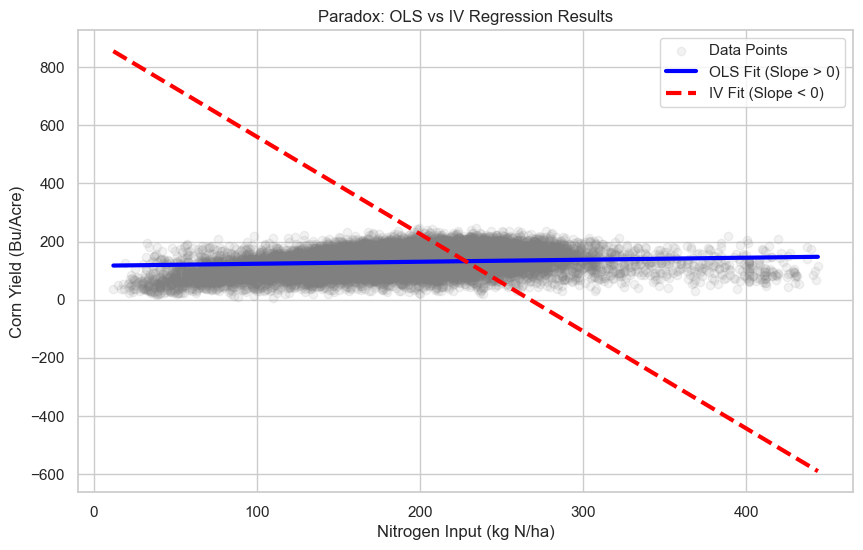

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置绘图风格
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# 1. 准备绘图数据
# 为了画出单纯的 Yield vs Ninput 关系，我们需要把其他变量固定在均值
# 这里我们简单画原始数据的散点图，叠加上回归拟合线

# 绘制原始数据散点 (为了避免点太密，可以只画一部分或者降低透明度)
plt.scatter(df_reg['Ninput'], df_reg['Yield'], alpha=0.1, color='gray', label='Data Points')

# 2. 绘制 OLS 拟合线 (Slope = 0.0697)
# 简单的线性方程: y = intercept + beta * x (忽略控制变量，仅做示意)
x_range = np.linspace(df_reg['Ninput'].min(), df_reg['Ninput'].max(), 100)
# 注意：截距我们取模型输出的 Intercept 近似值，或者让线穿过数据中心
y_ols = res_ols.params['Intercept'] + res_ols.params['Ninput'] * x_range
# 为了让线贴合数据中心，我们对其进行平移 (因为实际模型还有其他控制变量)
y_ols_adjusted = y_ols + (df_reg['Yield'].mean() - y_ols.mean())

plt.plot(x_range, y_ols_adjusted, color='blue', linewidth=3, label='OLS Fit (Slope > 0)')

# 3. 绘制 IV 拟合线 (Slope = -3.347)
y_iv = res_s2.params['Intercept'] + res_s2.params['Ninput_hat'] * x_range
y_iv_adjusted = y_iv + (df_reg['Yield'].mean() - y_iv.mean())

plt.plot(x_range, y_iv_adjusted, color='red', linewidth=3, linestyle='--', label='IV Fit (Slope < 0)')

# 添加图例和标签
plt.xlabel('Nitrogen Input (kg N/ha)')
plt.ylabel('Corn Yield (Bu/Acre)')
plt.title('Paradox: OLS vs IV Regression Results')
plt.legend()
plt.show()

In [5]:
# OLS 模型加入二次项
# Yield ~ Ninput + I(Ninput**2) + ...
formula_quad = 'Yield ~ Ninput + np.power(Ninput, 2) + Biotech_Rate + Precip + Temp + Trend + Trend_Sq + C(State)'

mod_quad = smf.ols(formula_quad, data=df_reg).fit()
print(mod_quad.summary().tables[1])


                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   83.4854      3.994     20.904      0.000      75.657      91.313
C(State)[T.INDIANA]         -5.5655      0.884     -6.299      0.000      -7.297      -3.834
C(State)[T.IOWA]             6.5810      0.865      7.612      0.000       4.886       8.276
C(State)[T.KANSAS]         -18.0784      0.900    -20.090      0.000     -19.842     -16.315
C(State)[T.MICHIGAN]       -23.6197      0.980    -24.114      0.000     -25.540     -21.700
C(State)[T.MINNESOTA]       -6.4427      1.008     -6.394      0.000      -8.418      -4.468
C(State)[T.MISSOURI]       -25.4676      0.768    -33.152      0.000     -26.973     -23.962
C(State)[T.NEBRASKA]         2.4993      0.894      2.796      0.005       0.747       4.252
C(State)[T.NORTH DAKOTA]   -39.6086      1.445    -27.409      0.000  

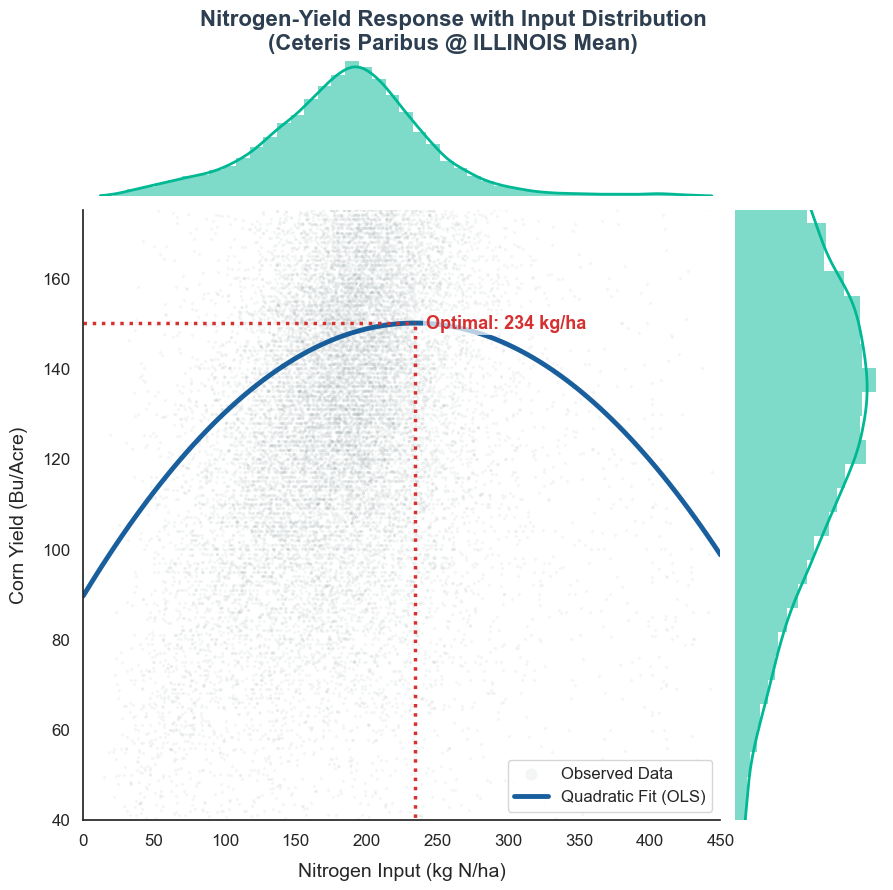

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ==========================================
# 0. 确保数据和模型已准备好
# ==========================================
if 'df_reg' not in locals() or 'df_predict' not in locals():
    raise ValueError("请先运行之前的数据清洗和模型预测代码！")

# ==========================================
# 1. 设置美观的主题风格
# ==========================================
sns.set_theme(style="white", font_scale=1.1)

# 定义配色
color_scatter = "#95a5a6"  # 灰色散点
color_line = "#004e92"     # 宝石蓝曲线
color_optimal = "#d63031"  # 胭脂红标记
color_hist = "#00b894"     # 薄荷绿直方图

# ==========================================
# 2. 创建 JointGrid 画布
# ==========================================
g = sns.JointGrid(data=df_reg, x='Ninput', y='Yield', height=9, ratio=4, space=0.1)

# ==========================================
# 3. 绘制更加精致的中间主图
# ==========================================

# A. 绘制背景散点 (极小且透明)
g.plot_joint(sns.scatterplot, color=color_scatter, s=5, alpha=0.1, linewidth=0, label='Observed Data')

# B. 绘制平滑的 OLS 拟合曲线
g.ax_joint.plot(df_predict['Ninput'], df_predict['Predicted_Yield'], 
                color=color_line, linewidth=3.5, alpha=0.9, label='Quadratic Fit (OLS)')

# C. 绘制最优投入标记线
g.ax_joint.vlines(x=optimal_N, ymin=0, ymax=peak_yield, colors=color_optimal, linestyles=':', linewidth=2.5)
g.ax_joint.hlines(y=peak_yield, xmin=0, xmax=optimal_N, colors=color_optimal, linestyles=':', linewidth=2.5)

# D. 添加标注文本
g.ax_joint.text(optimal_N + 8, peak_yield, f'Optimal: {optimal_N:.0f} kg/ha', 
                color=color_optimal, fontweight='bold', fontsize=13, va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2))

# ==========================================
# 4. 绘制清爽的边缘直方图
# ==========================================
# 注意：这里保留了之前修复的 line_kws
g.plot_marginals(sns.histplot, color=color_hist, alpha=0.5, bins=45, kde=True, 
                 linewidth=0, line_kws={'linewidth': 2})

# ==========================================
# 5. 细节调整与优化 (修复报错部分)
# ==========================================
# 设置标签
g.set_axis_labels('Nitrogen Input (kg N/ha)', 'Corn Yield (Bu/Acre)', fontsize=14, labelpad=10)

# 设置范围
g.ax_joint.set_xlim(0, 450)
g.ax_joint.set_ylim(40, 175)

# 移除边框
sns.despine(ax=g.ax_joint)
sns.despine(ax=g.ax_marg_x, left=True, bottom=True)
sns.despine(ax=g.ax_marg_y, left=True, bottom=True)
g.ax_marg_x.tick_params(bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(left=False, labelleft=False)

# --- 修复点开始 ---
# 使用 markerscale=4 来放大图例中的散点，替代手动修改 legendHandles
legend = g.ax_joint.legend(loc='lower right', frameon=True, framealpha=0.8, fontsize=12, markerscale=4)
# --- 修复点结束 ---

# 添加标题
plt.subplots_adjust(top=0.93)
g.fig.suptitle(f'Nitrogen-Yield Response with Input Distribution\n(Ceteris Paribus @ {ref_state} Mean)', 
               fontsize=16, fontweight='bold', color='#2c3e50')

plt.show()

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1. 准备数据
df = pd.read_csv('final_dataset_for_regression.csv')
rename_map = {
    'Yield_BuPerAcre': 'Yield',
    'Ninput (kg N/ha/yr)': 'Ninput',
    'ppt (inches)': 'Precip',
    'tmean (degrees F)': 'Temp',
    'Biotech_Rate': 'Biotech',
    'Natural_Gas_Price': 'Gas_Price',
    'Natural_Gas_Price_Index': 'Gas_Price',
    'Gas_Price': 'Gas_Price'
}
df = df.rename(columns=rename_map)
df = df.dropna(subset=['Yield', 'Ninput', 'Precip', 'Temp', 'Biotech', 'Gas_Price'])

# 辅助函数：手动 2SLS (方便循环调用)
def run_2sls(data, iv_col, control_formula):
    # Stage 1
    f1 = f"Ninput ~ {iv_col} + {control_formula}"
    s1 = smf.ols(f1, data=data).fit()
    data['Ninput_hat'] = s1.predict()
    
    # Stage 2
    f2 = f"Yield ~ Ninput_hat + {control_formula}"
    # 使用 Cluster SE (State level)
    s2 = smf.ols(f2, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['State']})
    return s2.params['Ninput_hat'], s2.pvalues['Ninput_hat']

# 存储结果的列表
results = []

print(">>> 开始稳健性检验...")

# ====================================================
# Test 1: Baseline (基准模型: lambda=6.25, 全样本)
# ====================================================
# HP Filter
gas_series = df[['Year', 'Gas_Price']].drop_duplicates().sort_values('Year').set_index('Year')
c, t = sm.tsa.filters.hpfilter(gas_series['Gas_Price'], lamb=6.25)
df['Gas_Cycle_6'] = df['Year'].map(c)
df['Gas_Trend_6'] = df['Year'].map(t)
df['Trend'] = df['Year'] - 1990
df['Trend_Sq'] = df['Trend'] ** 2
df['Precip_Sq'] = df['Precip'] ** 2
df['Temp_Sq'] = df['Temp'] ** 2

# Short (Controls: Trend + State FE)
coef_s, p_s = run_2sls(df, 'Gas_Cycle_6', 'Biotech + Precip + Temp + Trend + C(State)')
# Long (Controls: State FE)
coef_l, p_l = run_2sls(df, 'Gas_Trend_6', 'Biotech + Precip + Temp + C(State)')

results.append(['Baseline (Lambda=6.25)', coef_s, p_s, coef_l, p_l])

# ====================================================
# Test 2: Alternative Lambda (Lambda=100)
# ====================================================
c, t = sm.tsa.filters.hpfilter(gas_series['Gas_Price'], lamb=100)
df['Gas_Cycle_100'] = df['Year'].map(c)
df['Gas_Trend_100'] = df['Year'].map(t)

coef_s, p_s = run_2sls(df, 'Gas_Cycle_100', 'Biotech + Precip + Temp + Trend + C(State)')
coef_l, p_l = run_2sls(df, 'Gas_Trend_100', 'Biotech + Precip + Temp + C(State)')

results.append(['Lambda=100 (Smoother)', coef_s, p_s, coef_l, p_l])

# ====================================================
# Test 3: Subsample (2000-2019 only)
# ====================================================
df_sub = df[df['Year'] >= 2000].copy()
# Re-filter gas price for subsample is not needed, we use the decomposed values from full sample usually, 
# or decompose within subsample. Let's use decomposed values already in df.

coef_s, p_s = run_2sls(df_sub, 'Gas_Cycle_6', 'Biotech + Precip + Temp + Trend + C(State)')
coef_l, p_l = run_2sls(df_sub, 'Gas_Trend_6', 'Biotech + Precip + Temp + C(State)')

results.append(['Subsample (2000-2019)', coef_s, p_s, coef_l, p_l])

# ====================================================
# Test 4: Extra Weather Controls (Quadratic Weather)
# ====================================================
# Controls: Precip + Precip^2 + Temp + Temp^2 ...
extra_ctrl_short = 'Biotech + Precip + Precip_Sq + Temp + Temp_Sq + Trend + C(State)'
extra_ctrl_long = 'Biotech + Precip + Precip_Sq + Temp + Temp_Sq + C(State)'

coef_s, p_s = run_2sls(df, 'Gas_Cycle_6', extra_ctrl_short)
coef_l, p_l = run_2sls(df, 'Gas_Trend_6', extra_ctrl_long)

results.append(['Quadratic Weather Controls', coef_s, p_s, coef_l, p_l])

# ====================================================
# 输出汇总表格
# ====================================================
res_df = pd.DataFrame(results, columns=['Model Specification', 'Short-term Coef', 'Short P-val', 'Long-term Coef', 'Long P-val'])

print("\n=== Robustness Check Summary ===")
print(res_df.to_string(index=False, float_format="%.4f"))

print("\n>>> 判定标准:")
print("1. 如果 Short-term Coef 始终显著为正 (P<0.05)，说明短期效应极其稳健。")
print("2. 如果 Short > Long 的关系在大多数设定下保持，说明适应性假说成立。")

>>> 开始稳健性检验...

=== Robustness Check Summary ===
       Model Specification  Short-term Coef  Short P-val  Long-term Coef  Long P-val
    Baseline (Lambda=6.25)           1.6457       0.0021          1.3676      0.1497
     Lambda=100 (Smoother)          11.3720       0.0007         -4.8138      0.0269
     Subsample (2000-2019)           1.3132       0.0133          1.1707      0.0000
Quadratic Weather Controls           1.8269       0.0030          1.5524      0.0661

>>> 判定标准:
1. 如果 Short-term Coef 始终显著为正 (P<0.05)，说明短期效应极其稳健。
2. 如果 Short > Long 的关系在大多数设定下保持，说明适应性假说成立。


数据准备完成！样本量: 20478

正在生成 Figure 1 (分面板趋势图)...


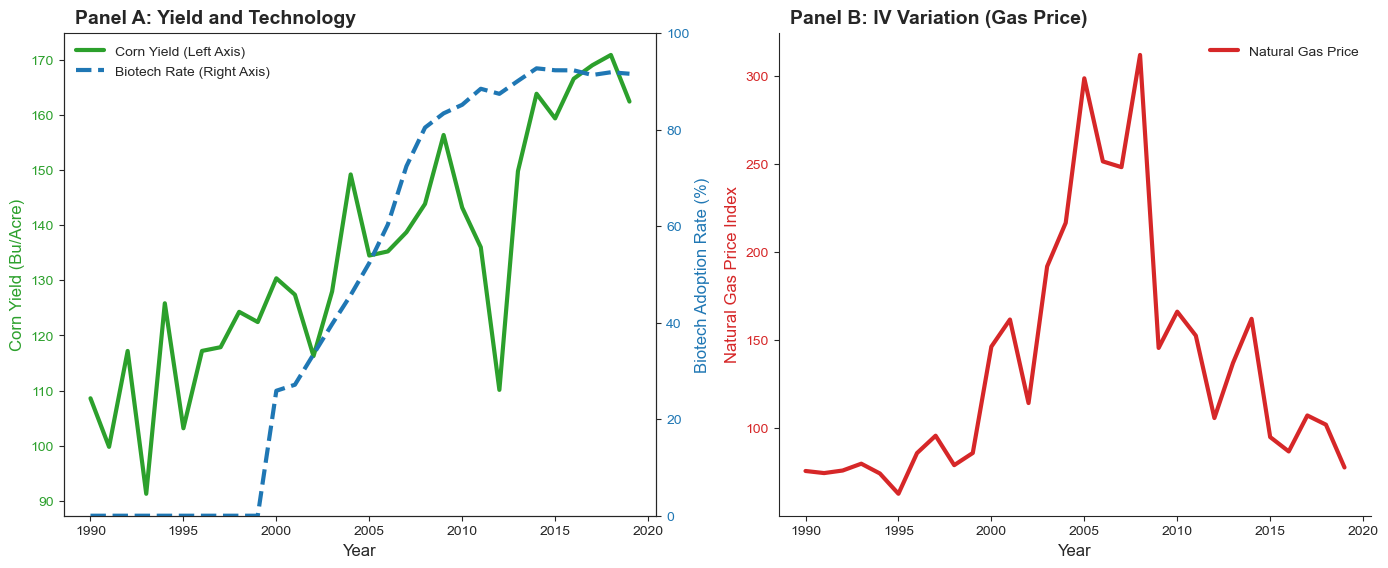


正在运行 IV 回归 (Table 2)...
Short-term Coef: 1.6456706224085584
Long-term Coef:  1.3676080349248243

正在生成 Figure 2 (Short vs Long)...


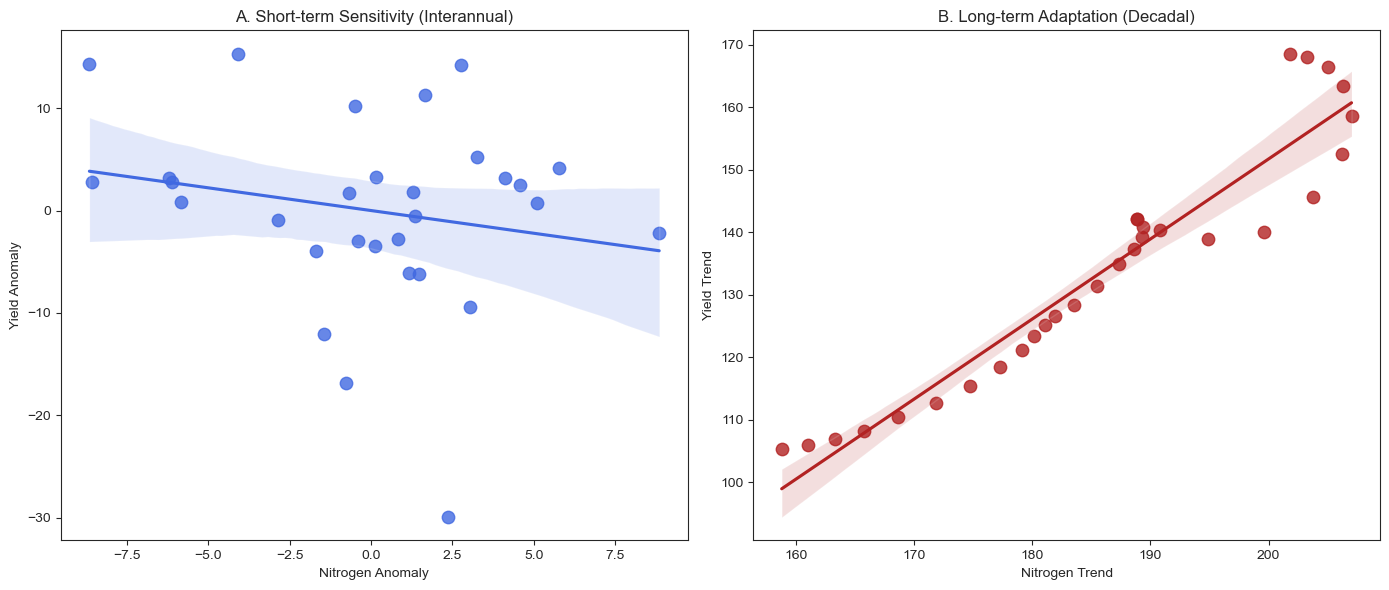


正在生成 Figure 3 (Decomposition)...


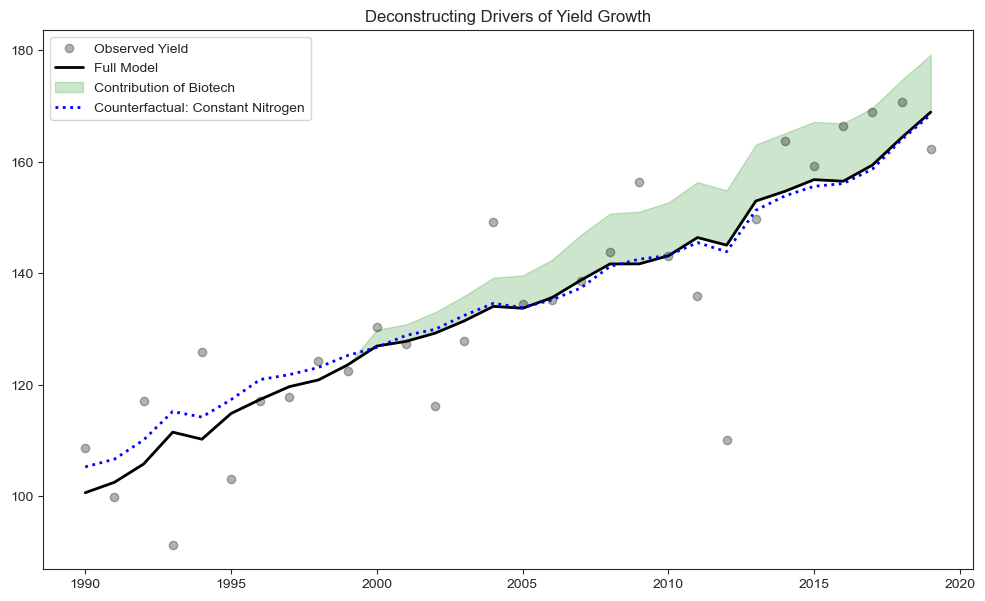


全部完成！所有图片已保存。


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 数据准备与清洗
# ==========================================
df = pd.read_csv('final_dataset_for_regression.csv')

# 统一重命名 (防止列名报错)
rename_map = {
    'Yield_BuPerAcre': 'Yield',
    'Ninput (kg N/ha/yr)': 'Ninput',
    'ppt (inches)': 'Precip',
    'tmean (degrees F)': 'Temp',
    'Biotech_Rate': 'Biotech',
    'Natural_Gas_Price': 'Gas_Price',
    'Natural_Gas_Price_Index': 'Gas_Price',
    'Gas_Price': 'Gas_Price' # 覆盖所有可能性
}
df = df.rename(columns=rename_map)
df = df.dropna(subset=['Yield', 'Ninput', 'Precip', 'Temp', 'Biotech', 'Gas_Price'])

# 添加时间趋势
df['Trend'] = df['Year'] - 1990
df['Trend_Sq'] = df['Trend'] ** 2

print("数据准备完成！样本量:", len(df))

# ==========================================
# 2. 生成 Figure 1: 典型事实 (Stylized Facts)
# ==========================================
print("\n正在生成 Figure 1 (分面板趋势图)...")
annual_stats = df.groupby('Year')[['Yield', 'Biotech', 'Gas_Price']].mean()

# 设置绘图风格
sns.set_style("ticks")
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(14, 6)) # 1行2列

# --------------------------------------------------
# Panel A: 产量与技术 (Yield & Biotech)
# --------------------------------------------------
# 左轴: Yield (绿色实线)
color_yield = 'tab:green'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Corn Yield (Bu/Acre)', color=color_yield, fontsize=12)
line1 = ax1.plot(annual_stats.index, annual_stats['Yield'], color=color_yield, linewidth=3, label='Corn Yield (Left Axis)')
ax1.tick_params(axis='y', labelcolor=color_yield)

# 右轴: Biotech (蓝色虚线)
ax2 = ax1.twinx()  
color_bio = 'tab:blue'
ax2.set_ylabel('Biotech Adoption Rate (%)', color=color_bio, fontsize=12)
line2 = ax2.plot(annual_stats.index, annual_stats['Biotech'], color=color_bio, linewidth=3, linestyle='--', label='Biotech Rate (Right Axis)')
ax2.tick_params(axis='y', labelcolor=color_bio)
ax2.set_ylim(0, 100) # 固定百分比范围

# 合并图例
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', frameon=False)

# 添加 Panel 标题 (放在图内左上角)
ax1.text(0.02, 1.02, 'Panel A: Yield and Technology', transform=ax1.transAxes, fontsize=14, fontweight='bold')

# --------------------------------------------------
# Panel B: 工具变量趋势 (Gas Price)
# --------------------------------------------------
# 单轴: Gas Price (红色实线)
color_gas = 'tab:red'
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Natural Gas Price Index', color=color_gas, fontsize=12)
ax3.plot(annual_stats.index, annual_stats['Gas_Price'], color=color_gas, linewidth=3, label='Natural Gas Price')
ax3.tick_params(axis='y', labelcolor=color_gas)

# 添加图例
ax3.legend(loc='upper right', frameon=False)

# 添加 Panel 标题
ax3.text(0.02, 1.02, 'Panel B: IV Variation (Gas Price)', transform=ax3.transAxes, fontsize=14, fontweight='bold')

# --------------------------------------------------
# 布局优化与保存
# --------------------------------------------------
plt.tight_layout()
plt.subplots_adjust(top=0.9) # 留出顶部空间给标题
sns.despine(ax=ax1, right=False) # Panel A 保留右脊柱(双轴)
sns.despine(ax=ax3)              # Panel B 去掉右脊柱

plt.savefig('Figure1_Stylized_Facts_Panel.png', dpi=300)
plt.show()

# ==========================================
# 3. 生成 Table 2: Short vs Long IV 回归
# ==========================================
print("\n正在运行 IV 回归 (Table 2)...")

# HP 滤波分解 IV
gas_series = df[['Year', 'Gas_Price']].drop_duplicates().sort_values('Year').set_index('Year')
cycle, trend = sm.tsa.filters.hpfilter(gas_series['Gas_Price'], lamb=6.25)
gas_decomp = pd.DataFrame({'Gas_Cycle': cycle, 'Gas_Trend': trend})
df = df.merge(gas_decomp, on='Year', how='left')

# 模型 1: Short-term IV (用 Cycle, 控制 Trend)
model_s1 = smf.ols('Ninput ~ Gas_Cycle + Biotech + Precip + Temp + Trend + C(State)', data=df).fit()
df['Ninput_hat_short'] = model_s1.predict()
model_short = smf.ols('Yield ~ Ninput_hat_short + Biotech + Precip + Temp + Trend + C(State)', data=df).fit()

# 模型 2: Long-term IV (用 Trend, 不控制 Trend)
model_l1 = smf.ols('Ninput ~ Gas_Trend + Biotech + Precip + Temp + C(State)', data=df).fit()
df['Ninput_hat_long'] = model_l1.predict()
model_long = smf.ols('Yield ~ Ninput_hat_long + Biotech + Precip + Temp + C(State)', data=df).fit()

print("Short-term Coef:", model_short.params['Ninput_hat_short'])
print("Long-term Coef: ", model_long.params['Ninput_hat_long'])

# ==========================================
# 4. 生成 Figure 2: Short vs Long 对比图 (红蓝散点)
# ==========================================
print("\n正在生成 Figure 2 (Short vs Long)...")
# 数据聚合与去趋势
df_annual = df.groupby('Year')[['Yield', 'Ninput']].mean()
y_cycle, y_trend = sm.tsa.filters.hpfilter(df_annual['Yield'], lamb=6.25)
n_cycle, n_trend = sm.tsa.filters.hpfilter(df_annual['Ninput'], lamb=6.25)
plot_data = pd.DataFrame({'Y_Cycle': y_cycle, 'Y_Trend': y_trend, 'N_Cycle': n_cycle, 'N_Trend': n_trend})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Short-term (Blue)
sns.regplot(x='N_Cycle', y='Y_Cycle', data=plot_data, ax=axes[0], color='royalblue', scatter_kws={'s':80})
axes[0].set_title('A. Short-term Sensitivity (Interannual)')
axes[0].set_xlabel('Nitrogen Anomaly'); axes[0].set_ylabel('Yield Anomaly')

# Long-term (Red)
sns.regplot(x='N_Trend', y='Y_Trend', data=plot_data, ax=axes[1], color='firebrick', scatter_kws={'s':80})
axes[1].set_title('B. Long-term Adaptation (Decadal)')
axes[1].set_xlabel('Nitrogen Trend'); axes[1].set_ylabel('Yield Trend')

plt.tight_layout()
plt.savefig('Science_Fig4_Short_vs_Long.png', dpi=300)
plt.show()

# ==========================================
# 5. 生成 Figure 3: 驱动力分解 (绿色填充图)
# ==========================================
print("\n正在生成 Figure 3 (Decomposition)...")
# 使用拟合最好的 Quadratic OLS 模型做预测
model_quad = smf.ols('Yield ~ Ninput + np.power(Ninput, 2) + Biotech + Precip + Temp + Trend + C(State)', data=df).fit()

# 基准 (1990-1995均值)
base = df[df['Year']<=1995][['Ninput']].mean()

# 预测
df['Pred_Full'] = model_quad.predict(df)
df['Pred_NoBiotech'] = model_quad.predict(df.assign(Biotech=0)) # 假设无 Biotech
df['Pred_NoMgmt'] = model_quad.predict(df.assign(Ninput=base['Ninput'])) # 假设氮肥不变

# 绘图
agg = df.groupby('Year')[['Yield', 'Pred_Full', 'Pred_NoBiotech', 'Pred_NoMgmt']].mean()

plt.figure(figsize=(12, 7))
plt.plot(agg.index, agg['Yield'], 'ko', alpha=0.3, label='Observed Yield')
plt.plot(agg.index, agg['Pred_Full'], 'k-', linewidth=2, label='Full Model')
# 绿色填充: Biotech 贡献
plt.fill_between(agg.index, agg['Pred_NoBiotech'], agg['Pred_Full'], color='green', alpha=0.2, label='Contribution of Biotech')
# 蓝色虚线: 氮肥不变
plt.plot(agg.index, agg['Pred_NoMgmt'], 'b:', linewidth=2, label='Counterfactual: Constant Nitrogen')

plt.title('Deconstructing Drivers of Yield Growth')
plt.legend(loc='upper left')
plt.savefig('Final_Integrated_Analysis.png', dpi=300)
plt.show()

print("\n全部完成！所有图片已保存。")